# Лабораторная работа №6

## Классификация текста
### Цель лабораторной работы: изучение методов классификации текстов.

### Требования к отчету:
- титульный лист;
- описание задания;
- текст программы;
- экранные формы с примерами выполнения программы.

### Для произвольного набора данных, предназначенного для классификации текстов, решите задачу классификации текста двумя способами:

- Способ 1. На основе CountVectorizer или TfidfVectorizer.
- Способ 2. На основе моделей word2vec или Glove или fastText.
- Сравните качество полученных моделей.

In [9]:
!pip install category-encoders

     |████████████████████████████████| 81kB 5.1MB/s 


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk import tokenize
import spacy
from spacy.lang.en import English
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import gensim.downloader

## Датасет

[Ссылка на датасет](https://www.kaggle.com/vstepanenko/disaster-tweets)

In [2]:
!unzip dizaster.zip

Archive:  dizaster.zip
  inflating: tweets.csv              


In [139]:
df = pd.read_csv('tweets.csv')
# df = df.get_chunk()
df

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


## Анализ данных

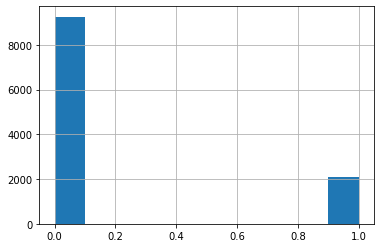

In [140]:
df.target.hist()

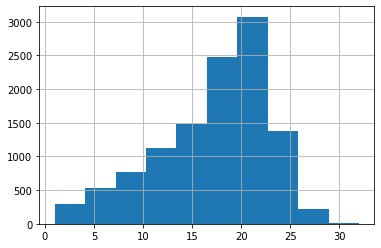

In [141]:
num_words = df.text.apply(lambda x: len(x.split()))
num_words.hist()

In [142]:
df.keyword.unique()

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'bush%20fires', 'casualties', 'casualty', 'catastrophe',
       'catastrophic', 'chemical%20emergency', 'cliff%20fall', 'collapse',
       'collapsed', 'collide', 'collided', 'collision', 'crash',
       'crashed', 'crush', 'crushed', 'curfew', 'cyclone', 'damage',
       'danger', 'dead', 'death', 'deaths', 'debris', 'deluge', 'deluged',
       'demolish', 'demolished', 'demolition', 'derail', 'derailed',
       'derailment', 'desol

In [143]:
df.keyword.isna().sum()

0

In [144]:
df.location.unique()

array([nan, 'New York City', 'Morgantown, WV', ...,
       'Blue State in a red sea', 'arohaonces', 'auroraborealis'],
      dtype=object)

In [145]:
df.location.isna().sum()

3418

## Подготовка категориальных признаков

In [146]:
from category_encoders import TargetEncoder

keyword_te = TargetEncoder()
df['keyword'] = keyword_te.fit_transform(df.keyword, df.target)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [147]:
location_te = TargetEncoder()
df['location'] = location_te.fit_transform(df.location, df.target)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [148]:
df.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [149]:
df

,id,keyword,location,text,target
0,0,0.588235,0.170568,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,0.588235,0.170568,Telangana: Section 144 has been imposed in Bha...,1
2,2,0.588235,0.199998,Arsonist sets cars ablaze at dealership https:...,1
3,3,0.588235,0.415533,Arsonist sets cars ablaze at dealership https:...,1
4,4,0.588235,0.170568,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...,...
11365,11365,0.150000,0.185928,Media should have warned us well in advance. T...,0
11366,11366,0.150000,0.185928,i feel directly attacked 💀 i consider moonbin ...,0
11367,11367,0.150000,0.396150,i feel directly attacked 💀 i consider moonbin ...,0
11368,11368,0.150000,0.185928,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


## Делим датасет на тренировочную и тестовую выборки

In [150]:
from sklearn.model_selection import train_test_split

df.drop(columns=['id'], inplace=True)

X = df[['keyword', 'location', 'text']]
y = df.target

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=123,
                                                    stratify=y, test_size=0.2)

x_train.shape, x_test.shape

((9096, 3), (2274, 3))

## Подготовка текстовых признаков с помощью TfidfVectorizer

In [151]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
nltk.download('stopwords')
stopwords_eng = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [152]:
from tqdm.notebook import tqdm 
from sklearn.feature_extraction.text import TfidfVectorizer

def prepare_text(text):
  t = re.sub(r'[^a-zA-Z0-9 \n]', '', text)
  t = re.sub('\s+', ' ', text)
  t = ' '.join([token.lemma_.lower() for token in nlp(t) if token not in stopwords_eng])
  return t

texts = x_train.text
train_texts_arr = []

for text in tqdm(texts):
  train_texts_arr.append(prepare_text(text))

texts_test = x_test.text
test_texts_arr = []

for text in tqdm(texts_test):
  test_texts_arr.append(prepare_text(text))

In [154]:
tfidf_vectorizer = TfidfVectorizer()

train_matrix_text = tfidf_vectorizer.fit_transform(train_texts_arr)
test_matrix_text = tfidf_vectorizer.transform(test_texts_arr)

train_matrix_text.shape, test_matrix_text.shape

((9096, 21060), (2274, 21060))

## Подготовка данных с помощью Glove

In [155]:
class GloveTokenizer:
  def __init__(self, glove_tokenizer, token_max_length, embedding_size):
    self.glove = glove_tokenizer
    self.token_length = token_max_length
    self.embedding_size = embedding_size

  def __getitem__(self, word):
    try:
      vector = glove_vectors.get_vector(word).reshape(1, self.embedding_size)
    except KeyError as e:
      vector = np.zeros((1, self.embedding_size))
    return vector


  def __padd(self, sentence):
    padded_sentence = np.zeros((self.token_length, self.embedding_size))
    for i, token in enumerate(sentence):
        padded_sentence[i] = token
    return padded_sentence
  
  def tokenize(self, sentence):
    encoded_sentence = []
    sentence = sentence.strip(' ').split(' ')
    for i in sentence:
      token = self.__getitem__(i)
      encoded_sentence.append(token)    
    return np.array(self.__padd(encoded_sentence), dtype=np.float16)

glove_vectors = gensim.downloader.load('glove-twitter-25') 

In [156]:
max_length_vector = 100
word_embedding_size = 25
tokenizer = GloveTokenizer(glove_vectors, 100, 25)   

In [157]:
from tqdm.notebook import tqdm 
from sklearn.feature_extraction.text import TfidfVectorizer

def prepare(t):
  t = re.sub(r'[^a-zA-Z0-9 ]', '', t)
  t = re.sub('\s+', ' ', t)
  lemmas = [token.lemma_.lower() for token in nlp(t) if token not in stopwords_eng]
  t = ' '.join(lemmas)
  vectors = tokenizer.tokenize(t)
  return vectors



train_texts = x_train.text
vectors_array_train = []
for text in tqdm(train_texts):
  vectors_array_train.append(prepare(text))
  
test_texts = x_test.text
vectors_array_test = []

for text in tqdm(test_texts):
  vectors_array_test.append(prepare(text))


In [158]:
vectors_array_train = np.array(vectors_array_train).reshape(-1, max_length_vector*word_embedding_size)
vectors_array_test = np.array(vectors_array_test).reshape(-1, max_length_vector*word_embedding_size)

vectors_array_train.shape, vectors_array_test.shape

((9096, 2500), (2274, 2500))

## Соберем итоговые данные для обучения и тестирования 

In [159]:
from scipy import sparse

numeric_train_sparse = sparse.csr_matrix(np.array(x_train.iloc[:, :2]).reshape(-1, 2))
numeric_test_sparse = sparse.csr_matrix(np.array(x_test.iloc[:, :2]).reshape(-1, 2))


train_data = sparse.hstack((train_matrix_text, numeric_train_sparse))
test_data = sparse.hstack((test_matrix_text, numeric_test_sparse))


train_data_glove = sparse.hstack((vectors_array_train, numeric_train_sparse))
test_data_glove = sparse.hstack((vectors_array_test, numeric_test_sparse))

train_data.shape, test_data.shape

((9096, 21062), (2274, 21062))

## KNeighborsClassifier с TfidfVectorizer

In [165]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors': [8, 10, 12, 15, 20]}
knn_clf = KNeighborsClassifier()

grid = GridSearchCV(knn_clf, params, cv=3, n_jobs=-1, scoring='roc_auc', verbose=4)

grid.fit(train_data, y_train)

best_neighbors = grid.best_params_['n_neighbors']

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   10.1s finished


In [166]:
best_neighbors

20

In [167]:
knn_best = KNeighborsClassifier(n_neighbors=best_neighbors)
knn_best.fit(train_data, y_train)

pred_knn = knn_best.predict(test_data)

print(classification_report(y_test, pred_knn))
print(roc_auc_score(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92      1851
           1       0.81      0.40      0.53       423

    accuracy                           0.87      2274
   macro avg       0.84      0.69      0.73      2274
weighted avg       0.86      0.87      0.85      2274

0.6880467142545146


## KNeighborsClassifier с Glove эмбеддингами

In [168]:
params = {'n_neighbors': [1, 2, 4, 6, 8, 10]}
knn_clf_glove = KNeighborsClassifier()

grid = GridSearchCV(knn_clf_glove, params, cv=3, n_jobs=-1,
                    scoring='roc_auc', verbose=4)

grid.fit(train_data_glove, y_train)

best_neighbors_glove = grid.best_params_['n_neighbors']

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.4min finished


In [169]:
best_neighbors_glove

10

In [170]:
knn_best_glove = KNeighborsClassifier(n_neighbors=best_neighbors_glove)
knn_best_glove.fit(train_data_glove, y_train)

pred_knn_glove = knn_best_glove.predict(test_data_glove)

print(classification_report(y_test, pred_knn_glove))
print(roc_auc_score(y_test, pred_knn_glove))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1851
           1       0.91      0.09      0.17       423

    accuracy                           0.83      2274
   macro avg       0.87      0.55      0.54      2274
weighted avg       0.84      0.83      0.77      2274

0.5462008268484353


## Итоговое сравнение обученных моделей


По итогу использования раздичных способов подготовки данных для обучения KNeighborsClassifier с подбором гипер параметров и кроссвалидацией, по выведенным метрикам f1 меры precision, recall и их взвешенных вариаций по классам, а также по roc_auc_score
можно отметить, что предобработка с помощью TfidfVectorizer показала себя лучше относительно roc_auc и немного лучше относительно взвешенных метрик из classification report. Учитывая, что классы не сбалансированы, следует больше учитывать roc_auc_score.